In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")

import wrangle
import split_scale


## Student grades

In [2]:
df = wrangle.wrangle_grades()
df.head()

,exam1,exam2,exam3,final_grade
0,100,90,95,96
1,98,93,96,95
2,85,83,87,87
3,83,80,86,85
4,93,90,96,97


In [3]:
train, test = split_scale.split_my_data(df)

In [4]:
predictions = pd.DataFrame({'actual': train.final_grade})

In [5]:
X = train[['exam1']]
y = train.final_grade
# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['final_grade ~ exam1'] = lm.predict(X)

In [6]:
lm.coef_, lm.intercept_

(array([0.76249314]), 21.96704090141759)

In [7]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.762 * exam1 + 21.967


In [8]:
X = train[['exam2']]
y = train.final_grade
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['final_grade ~ exam2'] = lm.predict(X)

In [9]:
X = train[['exam1','exam3']]
y = train.final_grade
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['final_grade ~ exam1 + exam3'] = lm.predict(X)

In [10]:
predictions.apply(lambda c: sklearn.metrics.mean_squared_error(predictions.actual, c))

actual                          0.000000
final_grade ~ exam1             3.405933
final_grade ~ exam2            16.067423
final_grade ~ exam1 + exam3     2.861172
dtype: float64

In [11]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

[Text(0.5, 1.0, 'final_grade ~ exam1 + exam3')]

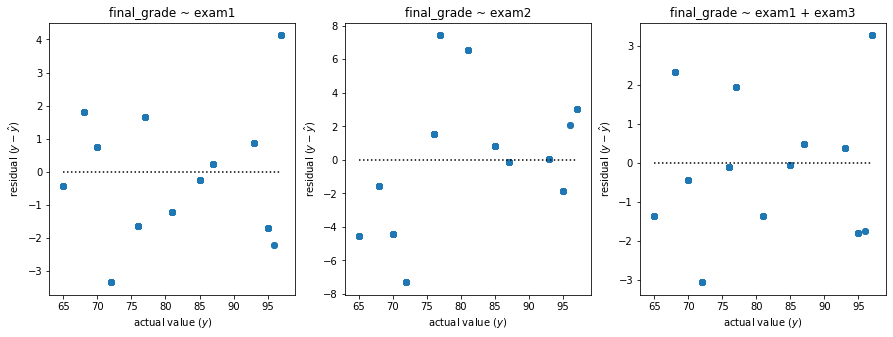

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(131) # 131 -- 1 row, 3 columns, 1st subplot
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam1'])
ax.set(title='final_grade ~ exam1')

plt.subplot(132) # 132 -- 1 row, 3 columns, 2nd subplot
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam2'])
ax.set(title='final_grade ~ exam2')

plt.subplot(133)
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam1 + exam3'])
ax.set(title='final_grade ~ exam1 + exam3')
# note the scale of the y-axis on all the subplots

Text(0.5, 0, 'actual')

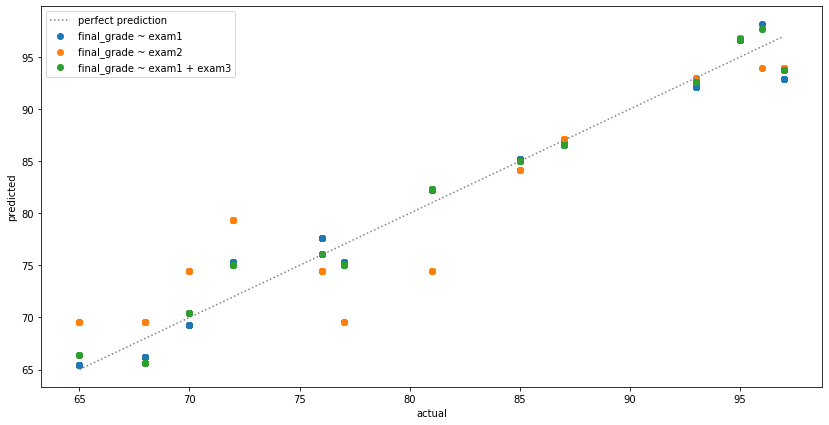

In [13]:
plt.figure(figsize=(14, 7))

# plt.scatter(x, y, label='whatever shows up in the legend')
plt.scatter(predictions.actual, predictions['final_grade ~ exam1'], label='final_grade ~ exam1')
plt.scatter(predictions.actual, predictions['final_grade ~ exam2'], label='final_grade ~ exam2')
plt.scatter(predictions.actual, predictions['final_grade ~ exam1 + exam3'], label='final_grade ~ exam1 + exam3')
# creates the straight line for perfect prediction
plt.plot(
    [predictions.actual.min(), predictions.actual.max()],
    [predictions.actual.min(), predictions.actual.max()],
    ls=':',
    label='perfect prediction',
    c='grey'
)
plt.legend()


plt.ylabel('predicted')
plt.xlabel('actual')

In [14]:
# evaluate the best model on the test data set
X = train[['exam1','exam3']]
y = train.final_grade
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
y_test = test.final_grade
y_test_predicted = lm.predict(test[['exam1', 'exam3']])

test_data_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predicted)
test_data_mse

3.9801217204793513

# Telco churn

In [15]:
df = wrangle.wrangle_telco()

In [16]:
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [17]:
train, test = split_scale.split_my_data(df)

In [18]:
train.head()

,customer_id,monthly_charges,tenure,total_charges
119,0707-HOVVN,75.50,70,5212.65
1424,8380-MQINP,20.30,55,1079.05
385,2307-FYNNL,109.05,65,7108.20
1140,6797-LNAQX,98.30,70,6859.50
1504,8879-XUAHX,116.25,71,8564.75


In [19]:
train = train[['monthly_charges','tenure','total_charges']]
test = test[['monthly_charges','tenure','total_charges']]

In [20]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [21]:
train.head(3)

,monthly_charges,tenure,total_charges
119,0.419607,0.729412,0.572659
1424,-1.169158,-0.130571,-1.035331
385,1.385242,0.442751,1.310036


In [22]:
test.head(3)

,monthly_charges,tenure,total_charges
305,-1.163401,0.844077,-0.870704
452,1.450002,0.557416,1.488589
917,1.389560,0.328087,1.287299


In [23]:
predictions = pd.DataFrame({
    'actual_total_charges': train.total_charges
})

In [24]:
X = train[['tenure']]
y = train.total_charges
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['tenure_lm'] = lm.predict(X)

In [25]:
lm.coef_, lm.intercept_

(array([0.63045407]), 6.679185851754575e-17)

In [26]:
predictions.head(3)

,actual_total_charges,tenure_lm
119,0.572659,0.459861
1424,-1.035331,-0.082319
385,1.310036,0.279134


In [27]:
X = train[['monthly_charges']]
y = train.total_charges
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['monthly_charges_lm'] = lm.predict(X)

In [28]:
X = train[['tenure','monthly_charges']]
# y can be 1-d
y = train.total_charges
# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['tenure_and_monthly_charges_lm'] = lm.predict(X)

In [29]:
predictions['baseline'] = predictions.actual_total_charges.mean()
predictions.head(3)

,actual_total_charges,tenure_lm,monthly_charges_lm,tenure_and_monthly_charges_lm,baseline
119,0.572659,0.459861,0.396864,0.557299,3.887428e-17
1424,-1.035331,-0.082319,-1.105787,-1.003895,3.887428e-17
385,1.310036,0.279134,1.310159,1.272574,3.887428e-17


In [30]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_total_charges, col))

actual_total_charges             0.000000
tenure_lm                        0.602528
monthly_charges_lm               0.105466
tenure_and_monthly_charges_lm    0.036412
baseline                         1.000000
dtype: float64

In [31]:
X = train[['tenure','monthly_charges']]
y = train.total_charges
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
y_test = test.total_charges
y_test_predicted = lm.predict(test[['tenure','monthly_charges']])
test_data_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predicted)
test_data_mse

0.03968858438491561

## Since the test data's mse value 0.0397 is pretty close to the train data's mse 0.0364, it's confident to say that the model performed best did pretty well.